# Effect on noise on classification of Schizophrenia data

It is important to characterize of noise propagation during shape analyis on the manifold and eventually the geometric machine learning (ML) that is performed on these shapes. In this notebook, I study this using an example schizophrenia dataset. 

In the notebook, we will see noise propagation in action - we shall discover how noise progation affects classification accuracy. We will find that geometric machine learning is resistant to noise as compared to tangent machine learning.

In [3]:
import geomstats.backend as gs
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
import geomstats.datasets.utils as data_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

INFO: Using numpy backend


## Loading data

- A dataset of 13 landmarks in 2D.
- Data for 28 different patients: 14 healthy controls and 14 schizophrenic patients.
- Data comes with label {0, 1} that classifying the corresponding patient. <br> normal: label = 0 <br> schizophrenic: label = 1.

In [6]:
def load_schizophrenia_data() :
    
    brains = pd.read_csv('schizophrenia_data.csv', header = 0, index_col = 0)
    brains_gs = brains.to_numpy(dtype = 'float64')

    data = gs.reshape(brains_gs, (28, 13, 2))
    labels = np.append(gs.zeros(14), gs.ones(14))
    patients = gs.arange(28)

    return data, labels, patients

brains, labels, patients = load_schizophrenia_data()
print(f"There are {len(labels)} sets of landmarks:"
      f" {sum(labels==0)} healthy controls and {sum(labels==1)} schizophrenic patients.")
    
m_ambient = 2
k_landmarks = 13
preshape = PreShapeSpace(m_ambient = m_ambient, k_landmarks = k_landmarks)
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)
    
landmarks_preshape = preshape.projection(brains)
landmarks_shape = preshape.align(point=landmarks_preshape, base_point=landmarks_preshape[0])

There are 28 sets of landmarks: 14 healthy controls and 14 schizophrenic patients.


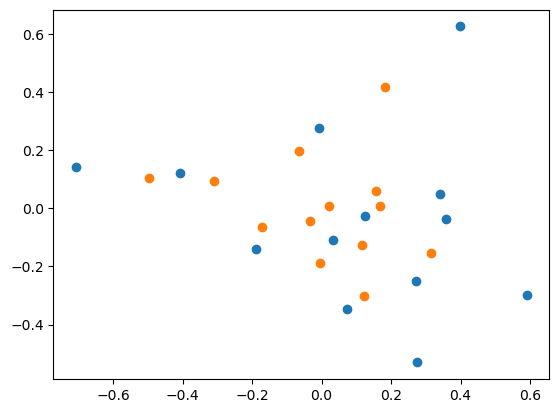

In [7]:
# Checking by plotting an example
plt.scatter(brains[2,:,0],brains[2,:,1])
plt.scatter(landmarks_shape[2,:,0],landmarks_shape[2,:,1])

## Splitting data into train and test

In [39]:
from sklearn.model_selection import train_test_split

X = landmarks_shape; y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"The dataset has {len(X)} landmarks.")
print(f"The train set has {len(X_train)} landmarks.")
print(f"The test set has {len(X_test)} landmarks.")

The dataset has 28 landmarks.
The train set has 21 landmarks.
The test set has 7 landmarks.


## Performing Logistic Regression (Tangent ML)
 Always gives very bad results, classifies everything as 0 (or 1). I will thus not use this method further in this notebook

In [40]:
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=kendall_metric)),
        ("classifier", LogisticRegression()),
    ]
)

lr_pipeline.fit(X_train, y_train)

print(f"Logistic regression score: {lr_pipeline.score(X_test, y_test):.2f}.")
print(lr_pipeline.predict(X_test))
print(y_test)

Logistic regression score: 0.29.
[0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 1.]


## Using K - nearest neighbours classifier (Tangent ML)
Accuracy upto 85 %

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=kendall_metric)),
        ("classifier", KNeighborsClassifier()),
    ]
)

knn_pipeline.fit(X_train, y_train)
print(f"K nearest neighbours score: {knn_pipeline.score(X_test, y_test):.2f}.")

print(knn_pipeline.predict(X_test))
print(y_test)

K nearest neighbours score: 0.71.
[0. 1. 1. 1. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 1.]


## Using geometric ML i.e. classification on the manifold - Riemannian Minimum Distance to Mean (RMDM)
Accuracy upto 85 %.
Sometimes better than tangent ML.

In [42]:
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean

mdm = RiemannianMinimumDistanceToMean(
    riemannian_metric=kendall_metric)
mdm.fit(X_train, y_train)
print(f"Manifold learning score: {mdm.score(X_test, y_test):.2f}")
print(mdm.predict(X_test))
print(y_test)

Manifold learning score: 0.71
[0. 1. 1. 1. 0. 1. 1.]
[1. 1. 1. 1. 0. 0. 1.]


## Adding noise to Schizophrenia dataset

We add noise to dataset which can imitate the noise naturally present due to human error or deep learning mislabeling. Dataset with shot noise are generated by adding Gaussian noise to each point in the dataset with some probability. Such errors can naturally occur in case of landmarks data if some points in the dataset are much easier to label than other points (e.g. image has poor resolution near edges, motion blur, etc.) which only causes noise for certain points.

In [43]:
def shot_noise(set_of_landmarks, probability, sigma) :
    """Add gaussian shot noise to a data set of landmarks
    
    Parameters
    ----------
    set_of_landmarks : array-like
        Original data set
    probability : float, in the range 0 to 1
        Probability of getting introducing an error at each landmark
    sigma : float
        Sigma of the Gaussian distribution
​
    Returns
    -------
    noisy_data : array-like, of same dimensions as set_of_landmarks
        Data set with noise added to the original set of landmarks
    """
    rand_choice = gs.random.choice([0, 1], set_of_landmarks.shape, p = [1 - probability, probability])
    rand_norm = gs.random.normal(0.0, sigma, size = set_of_landmarks.shape)
    noisy_data = set_of_landmarks + rand_norm * rand_choice
    
    return noisy_data

## Testing both tangent ML and geometric ML on the generated noisy dataset

In [145]:
probability = 0.3; sigma = 0.3
noisy_train = shot_noise(X_train, probability, sigma); noisy_test = shot_noise(X_test, probability, sigma)

knn_pipeline.fit(noisy_train, y_train); knn_score = knn_pipeline.score(noisy_test, y_test)
print(f"K nearest neighbours score: {knn_score:.2f}.")
print(knn_pipeline.predict(noisy_test));print(y_test)

mdm.fit(noisy_train, y_train); mdm_score = mdm.score(noisy_test, y_test)
print(f"Manifold learning score: {mdm_score:.2f}")
print(mdm.predict(noisy_test));print(y_test)

K nearest neighbours score: 0.29.
[0. 0. 0. 0. 0. 1. 1.]
[1. 1. 1. 1. 0. 0. 1.]
Manifold learning score: 0.71
[1. 0. 0. 1. 0. 0. 1.]
[1. 1. 1. 1. 0. 0. 1.]


## Reapeating the process many times to see some trends
The exact value of accuracy can depend on each rund because of the way the training and test data were split. To comment quantitatively on how the score (accuracy) of the ML classifiers change upon adding noise, it is better to execute the processes many times and compare the mean accuracies.

In [ ]:
def get_lr_accuracies(probability,sigma,runs):
    """Get accuracy for logistic regression on dataset for multiple runs
    
    Parameters
    ----------
    probability : float, in the range 0 to 1
        Probability of getting introducing an error at each landmark
    sigma : float
        Sigma of the Gaussian distribution
    runs : integer
        Number of times ML pipeline is executed
​
    Returns
    -------
    lr_scores : array-like, of dimension runs
        List of scores of the logistic regression model on original dataset for each run
    lr_scores_noisy : array-like, of dimension runs
        List of scores of the logistic regression model on noisy dataset for each run    
    """
    lr_scores = []; lr_scores_noisy = []
    
    for iter in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        noisy_train = shot_noise(X_train, probability, sigma)
        noisy_test = shot_noise(X_test, probability, sigma)

        lr_pipeline.fit(X_train, y_train)
        lr_scores.append(lr_pipeline.score(X_test, y_test))
        lr_pipeline.fit(noisy_train, y_train)
        lr_scores_noisy.append(lr_pipeline.score(noisy_test, y_test))

    return lr_scores, lr_scores_noisy

def get_mdm_accuracies(probability,sigma,runs):
    """Get accuracy for Riemannian Minimum Distance to Mean classification on dataset for multiple runs
    
    Parameters
    ----------
    probability : float, in the range 0 to 1
        Probability of getting introducing an error at each landmark
    sigma : float
        Sigma of the Gaussian distribution
    runs : integer
        Number of times ML pipeline is executed
​
    Returns
    -------
    mdm_scores : array-like, of dimension runs
        List of scores of the Riemannian Minimum Distance to Mean classification model on original dataset for each run
    mdm_scores_noisy : array-like, of dimension runs
        List of scores of theRiemannian Minimum Distance to Mean classification model on noisy dataset for each run    
    """
    mdm_scores = []; mdm_scores_noisy = []
    
    for iter in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        noisy_train = shot_noise(X_train, probability, sigma)
        noisy_test = shot_noise(X_test, probability, sigma)

        mdm.fit(X_train, y_train)
        mdm_scores.append(mdm.score(X_test, y_test))
        mdm.fit(noisy_train, y_train)
        mdm_scores_noisy.append(mdm.score(noisy_test, y_test))

    return mdm_scores, mdm_scores_noisy

In [46]:
def get_knn_accuracies(probability,sigma,runs):
    
    knn_scores = []; knn_scores_noisy = []
    
    for iter in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        noisy_train = shot_noise(X_train, probability, sigma)
        noisy_test = shot_noise(X_test, probability, sigma)

        knn_pipeline.fit(X_train, y_train)
        knn_scores.append(knn_pipeline.score(X_test, y_test))
        knn_pipeline.fit(noisy_train, y_train)
        knn_scores_noisy.append(knn_pipeline.score(noisy_test, y_test))

    return knn_scores, knn_scores_noisy

## Next, we will execute the ML pipelines for various values of probabilities and sigma

- We'll compare the trends for the classification models which give reasonable scores: <br> k-nearest neighbour and Riemannian minimum distance to mean.
- We'll use the following range of paramters for the noise:

In [87]:
probabilities = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0]
sigmas = [0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 0.15, 0.20, 0.25]

## Trends for K-nearest neighbour classification model

In [127]:
runs = 50
knn_scores_noisy_p = np.empty((len(probabilities), runs))
knn_scores_noisy_s = np.empty((len(sigmas), runs))

for iter, probability in enumerate(probabilities):
    knn_scores, knn_scores_noisy_p[iter] = get_knn_accuracies(probability=probability, sigma=0.04, runs=runs)

for iter, sigma in enumerate(sigmas):
    _, knn_scores_noisy_s[iter] = get_knn_accuracies(probability=0.04, sigma=sigma, runs=runs)

Text(0.5, 1.0, 'KNN - Variation of mean accuracy with probability of shot noise')

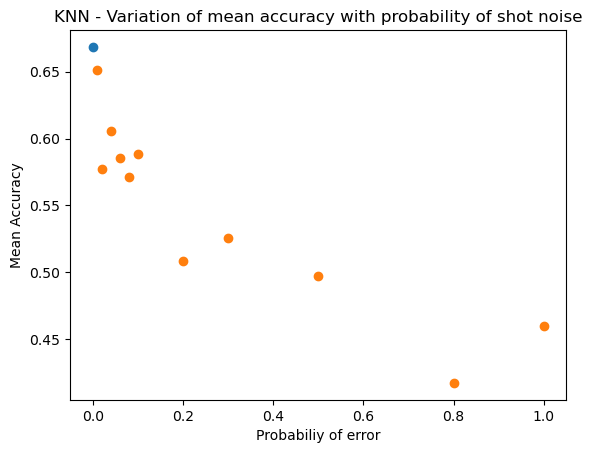

In [133]:
plt.figure()
plt.scatter(0,np.mean(knn_scores))
plt.scatter(probabilities, np.mean(knn_scores_noisy_p, axis=1))
plt.xlabel('Probabiliy of error')
plt.ylabel('Mean Accuracy')
plt.title('KNN - Variation of mean accuracy with probability of shot noise')

Text(0.5, 1.0, 'KNN - Histogram of mean accuracy for some probability values')

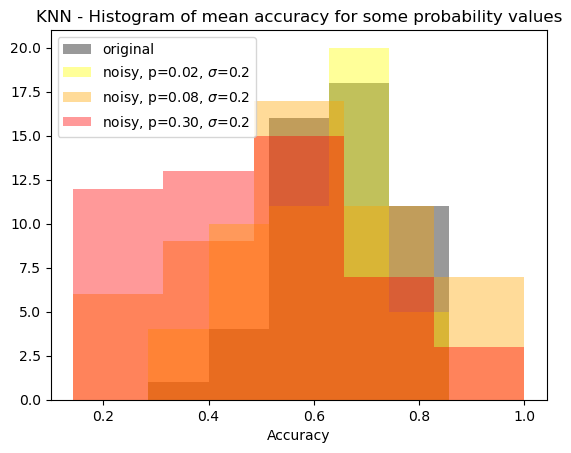

In [139]:
plt.figure(); bins = 5
plt.hist(knn_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(knn_scores_noisy_p[2], bins, alpha=0.4, label=f'noisy, p={probabilities[1]:.2f}, $\sigma$=0.2', color='yellow')
plt.hist(knn_scores_noisy_p[5], bins, alpha=0.4, label=f'noisy, p={probabilities[4]:.2f}, $\sigma$=0.2', color='orange')
plt.hist(knn_scores_noisy_p[8], bins, alpha=0.4, label=f'noisy, p={probabilities[7]:.2f}, $\sigma$=0.2', color='red')
plt.xlabel('Accuracy'); plt.legend()
plt.title('KNN - Histogram of mean accuracy for some probability values')

Text(0.5, 1.0, 'KNN - Variation of mean accuracy with variance of shot noise')

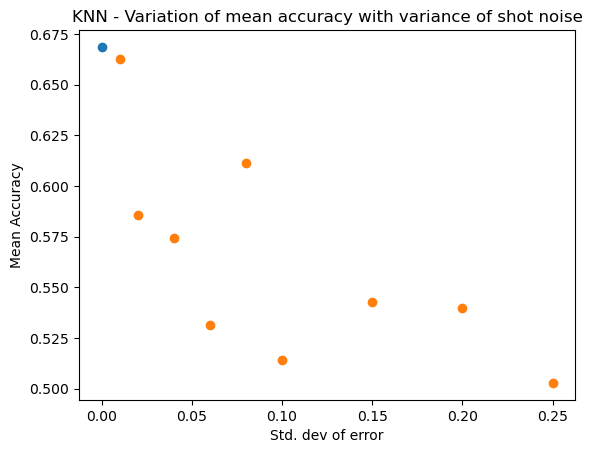

In [136]:
plt.scatter(0, np.mean(knn_scores))
plt.scatter(sigmas, np.mean(knn_scores_noisy_s, axis=1))
plt.xlabel('Std. dev of error')
plt.ylabel('Mean Accuracy')
plt.title('KNN - Variation of mean accuracy with variance of shot noise')

Text(0.5, 1.0, 'KNN - Histogram of mean accuracy for some $\\sigma$ values')

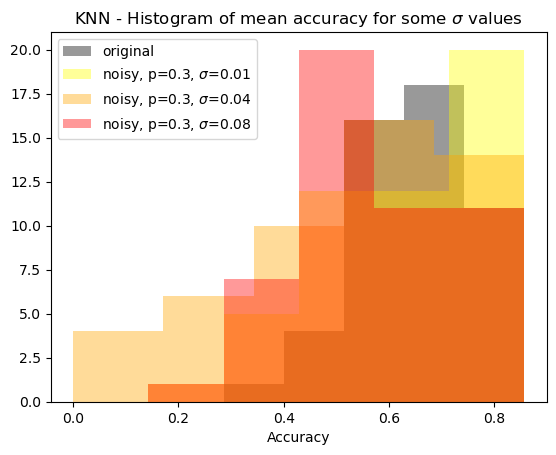

In [137]:
plt.figure()
bins = 5
plt.hist(knn_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(knn_scores_noisy_s[2], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[0]:.2f}', color='yellow')
plt.hist(knn_scores_noisy_s[5], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[2]:.2f}', color='orange')
plt.hist(knn_scores_noisy_s[8], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[4]:.2f}', color='red')
plt.xlabel('Accuracy')
plt.legend()
plt.title('KNN - Histogram of mean accuracy for some $\sigma$ values')

## Results:
1) Mean accuracy (mean score) for k-nearest neighbour classifier decreases with increasing probability and sigma.
2) Increase in probability/sigma makes the distribution of accuracies (scores) broader with a lower accuracy peak.

## Trends for Riemannian minimum distance to mean classification model
We'll run the pipeline 50 times for various values of probalities and sigma.

In [116]:
runs = 50
mdm_scores_noisy_p = np.empty((len(probabilities), runs))
mdm_scores_noisy_s = np.empty((len(sigmas), runs))

for iter, probability in enumerate(probabilities):
    mdm_scores, mdm_scores_noisy_p[iter] = get_mdm_accuracies(probability=probability, sigma=0.04, runs=runs)

for iter, sigma in enumerate(sigmas):
    _, mdm_scores_noisy_s[iter] = get_mdm_accuracies(probability=0.04, sigma=sigma, runs=runs)

Text(0.5, 1.0, 'MDM - Variation of mean accuracy with probability of shot noise')

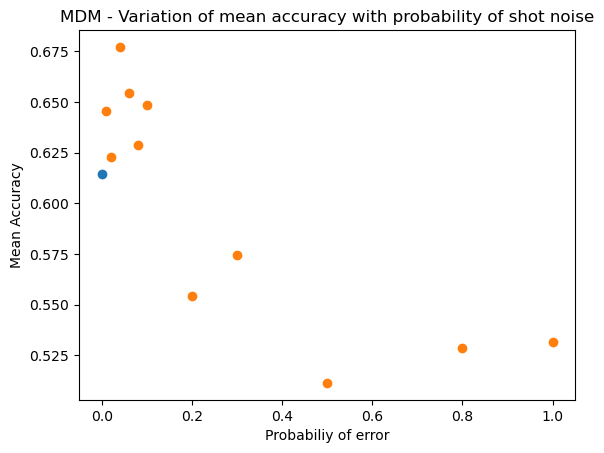

In [140]:
plt.figure()
plt.scatter(0,np.mean(mdm_scores))
plt.scatter(probabilities, np.mean(mdm_scores_noisy_p, axis=1))
plt.xlabel('Probabiliy of error')
plt.ylabel('Mean Accuracy')
plt.title('MDM - Variation of mean accuracy with probability of shot noise')

Text(0.5, 1.0, 'MDM - Histogram of mean accuracy for some probability values')

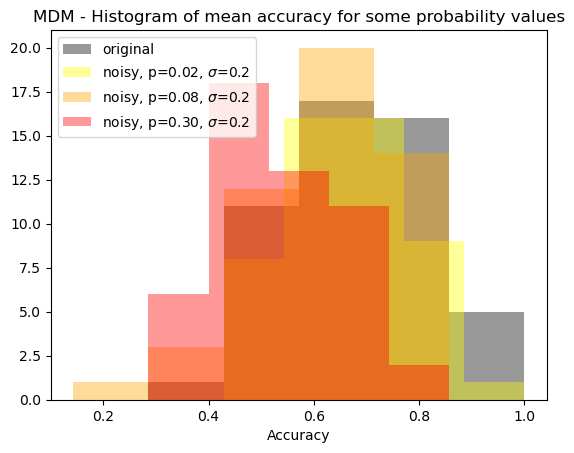

In [141]:
plt.figure()
bins = 5
plt.hist(mdm_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(mdm_scores_noisy_p[3], bins, alpha=0.4, label=f'noisy, p={probabilities[1]:.2f}, $\sigma$=0.2', color='yellow')
plt.hist(mdm_scores_noisy_p[6], bins, alpha=0.4, label=f'noisy, p={probabilities[4]:.2f}, $\sigma$=0.2', color='orange')
plt.hist(mdm_scores_noisy_p[9], bins, alpha=0.4, label=f'noisy, p={probabilities[7]:.2f}, $\sigma$=0.2', color='red')
plt.xlabel('Accuracy')
plt.legend()
plt.title('MDM - Histogram of mean accuracy for some probability values')

Text(0.5, 1.0, 'MDM - Variation of mean accuracy with variance of shot noise')

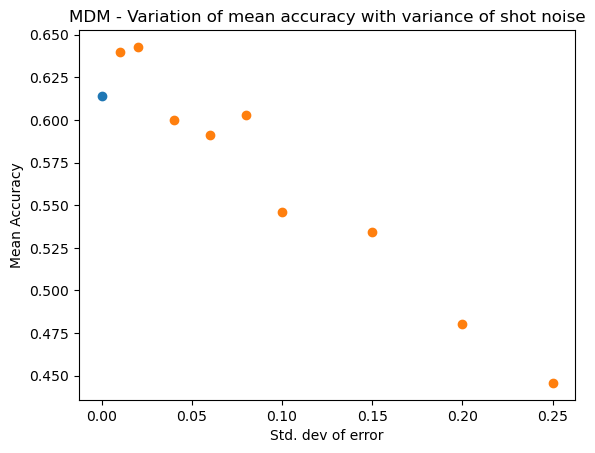

In [142]:
plt.scatter(0, np.mean(mdm_scores))
plt.scatter(sigmas, np.mean(mdm_scores_noisy_s, axis=1))
plt.xlabel('Std. dev of error')
plt.ylabel('Mean Accuracy')
plt.title('MDM - Variation of mean accuracy with variance of shot noise')

Text(0.5, 1.0, 'MDM - Histogram of mean accuracy for some $\\sigma$ values')

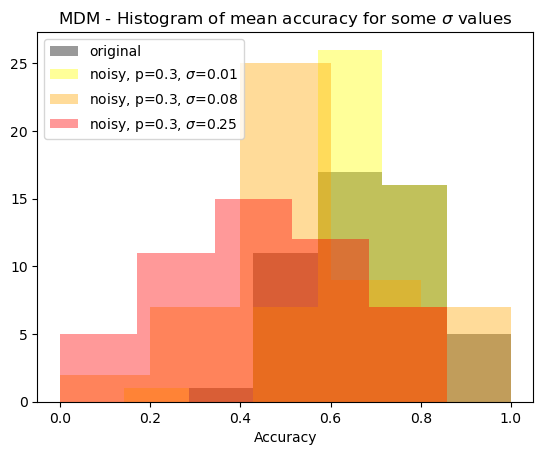

In [143]:
plt.figure(); bins = 5
plt.hist(mdm_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(mdm_scores_noisy_s[2], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[0]:.2f}', color='yellow')
plt.hist(mdm_scores_noisy_s[5], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[4]:.2f}', color='orange')
plt.hist(mdm_scores_noisy_s[8], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[8]:.2f}', color='red')
plt.xlabel('Accuracy'); plt.legend()
plt.title('MDM - Histogram of mean accuracy for some $\sigma$ values')

## Results:
1) Mean accuracy (mean score) is not affected by lower levels of noise! <br> Not affected by noisy data with upto ~$20$% probability of shot noise and gaussian noise around each landmark with standard deviation upto ~$10$%.
2) Higher noise levels decrease classifiation accuracy, similar to tangent ML.
2) Increase in probability/sigma makes the distribution of accuracies (scores) broader with a lower accuracy peak.

## Summary and Outlook:

- K-nearest neighbour (tangent ML) and Minuminum distance to mean classifiers can reasonably classify the schizophrenia dataset.

- Adding high levels of noise reduces the classification accuracy for both methods as expected.

- Rimannian distance to mean classifier i.e. for classification on the manifold is resistant to small levels of noise, unlike tangent ML.<br>

**Hypothesis:** Projecting onto the tangent space can often distort and directionally amplify the noise affecting the ML models. Geometric machine learning is free from such problems, thus classification on the manifold is not affected by small levels of noise.

## Summary and Outlook:

- If we impose an accuracy cutoff that we require for our classification model (say ~$60$%), we can use the trends in mean accuracy to estimate the level of noise the classifier is tolerant to. This can help us comment on whether our classifier can accurately classify noisy data. <br> Eg: with a 60% accuracy cutoff, we can say from our above plots that our classifier is tolerant to noisy data with upto ~$6$% probability of shot noise and gaussian noise around each landmark with standard deviation upto ~$4$%.

Note: We are working with smaller datasets here, so the classification accuracies is low. But for larger datasets, we could use a similar procedure to estimate the noise tolerance demanding much larger accuracies.